# Binomial Trees

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from option_param import Parameters

In [3]:
param = Parameters(100,100,0,1,0.05,0.0,0.2)
param.get_attribute()

stock     : 100.0
strike    : 100.0
t         : 0.0
T         : 1.0
tau       : 1.0
rate      : 0.05
dividend  : 0.0
vol       : 0.2


## CRR: Cox, Ross, and Rubinstein (1979): 

In [4]:
class BinomialTree:
    """
    Class Binomial tree. 
    By default use CRR methodology

    
    --------------------------------
    Note: 
        if Volatility paramter is given, u and d are calculated
        automatically. 
        if instead parameter u and d are given,
        you can upload directly into the object as:
        obj = Tree(param, n)
        obj.u = 1.2
        obj.d = 1/1.2
        
    Future Idea: 
    To use the Binomial Asset Pricing Model as per Steven E. Shreve
    book's Stochastic Calculos for Finance I, use obj.set_apm(u, d),
    where u and d have to be manually inputed. 
    """
    
    def __init__(self, param, n):
        self.param = param      # Parameter object
        self.n = n              # number of timestep
        
        self.dt = self.param.tau / self.n
        
        self.u = 0 # up movement
        self.d = 0 # down movement

        self.p = 0 # probability 
        
        
        self.t_stock = np.zeros((n+1,n+1))
      
        self.set_crr() # By default using the CRR model
                
    def set_crr(self):
        """
        Set parameter according to the Cox, Ross and Rubinstein (1979) model
        """
        
        self.u = np.exp(self.param.vol * np.sqrt(self.dt)) # up
        self.d = 1/self.u # down (faster)
        
        self.p = (np.exp(self.param.rate * self.dt) - self.d) / (self.u - self.d)

    def set_apm(self, u, d):
        """
        Set parameter according the The Binomial Asset Pricing Model
        Steven E. Schreve
        Stochastic Calculus for Finance 1: The Binomial Asset Pricing Model 
        """
        self.u = u
        self.d = d
        self.p = (1 + self.param.rate - self.d) / (self.u - self.d)
            
    def set_tree(self):
        """
        Summary: 
            Calculate Binomial Tree using CRR method
        Comment:
            - Faster version. Instead of using a double loop, 
              you can vectorise one of the loop
            - For european option pricing,
              only Terminal Stock price required. 
        """
        for i in range(self.n+1):
            self.t_stock[:i+1,i:i+1] = (self.param.stock * self.u**(np.arange(i,-1,-1)) \
                * self.d**(np.arange(0,i+1,1))).reshape(-1,1)
            
    
    def set_european(self):

        self.t_stock[:,-1] = (self.param.stock * self.u**(np.arange(self.n, -1, -1)) \
                * self.d**(np.arange(0,self.n + 1, 1)))

        self.t_eu_c = self.t_stock.copy()
        self.t_eu_p = self.t_stock.copy()
        
        #Intrinsic option price at the final node
        self.t_eu_c[:,-1] =  np.maximum(self.t_eu_c[:,-1] \
            - self.param.strike, 0.0) # call

        self.t_eu_p[:,-1] =  np.maximum(self.param.strike \
            - self.t_eu_p[:,-1], 0.0) # put

        # Backward tree:
        for i in range(self.n,0,-1):
            # Call
            self.t_eu_c[:i, i-1] = np.exp(-self.param.rate * self.dt) \
                * (self.p * self.t_eu_c[:i, i] \
                + (1 - self.p) * self.t_eu_c[1:i+1, i])

            # Put
            self.t_eu_p[:i, i-1] = np.exp(-self.param.rate * self.dt) \
                * (self.p * self.t_eu_p[:i, i] \
                + (1 - self.p) * self.t_eu_p[1:i+1, i])


    def set_american(self):

        self.set_tree()

        self.t_am_c = self.t_stock.copy()
        self.t_am_p = self.t_stock.copy()

        self.t_am_c[:,-1] = np.maximum(self.t_stock[:,-1] \
            - self.param.strike,0.0)

        self.t_am_p[:,-1] = np.maximum(self.param.strike \
            - self.t_stock[:,-1], 0.0)

        for i in range(self.n-1,-1,-1):

            # Call
            ex_c = self.t_stock[:,i] - self.param.strike
            wait_c = np.exp(-self.param.rate * self.dt) \
                * (self.p * self.t_am_c[:i+1, i+1] \
                + (1 - self.p) * self.t_am_c[1:i+2, i+1])

            self.t_am_c[:i+1,i] = np.maximum(ex_c[:i+1], wait_c[:i+1])

            # Put
            ex_p =  self.param.strike - self.t_stock[:,i]
            wait_p = np.exp(-self.param.rate * self.dt) \
                * (self.p * self.t_am_p[:i+1, i+1] \
                + (1 - self.p) * self.t_am_p[1:i+2, i+1])

            self.t_am_p[:i+1,i] = np.maximum(ex_p[:i+1], wait_p[:i+1])     
               

### Function

Check algorithm: (works!)
- European put: https://www.youtube.com/watch?v=gOStLKAehjA
- American put: https://www.youtube.com/watch?v=nr8Rw8RYSdU

In [5]:
test = Parameters(102, 100, 0, 0.5, 0.02, 0.0, 0.2000773189775976)
t = BinomialTree(test, 4)
t.set_crr()
t.u = 1.0733 # set u and d manually
t.d = 0.9317
t.set_european()
t.set_american()

In [6]:
t.t_stock

array([[102.        , 109.4766    , 117.50123478, 126.11407529,
        135.35823701],
       [  0.        ,  95.0334    , 101.99934822, 109.47590044,
        117.50048395],
       [  0.        ,   0.        ,  88.54261878,  95.03279274,
        101.99869644],
       [  0.        ,   0.        ,   0.        ,  82.49515792,
         88.54205299],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         76.86073863]])

In [7]:
t.t_eu_c

array([[ 7.26157935, 11.64435194, 17.99928905, 26.36338857, 35.35823701],
       [ 0.        ,  2.91514148,  5.34768248,  9.72526313, 17.50048395],
       [ 0.        ,  0.        ,  0.49718409,  0.9968551 ,  1.99869644],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [8]:
t.t_eu_p

array([[ 4.26777422,  1.42153265,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  7.13539353,  2.85018792,  0.        ,  0.        ],
       [ 0.        ,  0.        , 11.45633906,  5.71465679,  0.        ],
       [ 0.        ,  0.        ,  0.        , 17.25539928, 11.45794701],
       [ 0.        ,  0.        ,  0.        ,  0.        , 23.13926137]])

In [9]:
t.t_am_c

array([[ 7.26157935, 11.64435194, 17.99928905, 26.36338857, 35.35823701],
       [ 0.        ,  2.91514148,  5.34768248,  9.72526313, 17.50048395],
       [ 0.        ,  0.        ,  0.49718409,  0.9968551 ,  1.99869644],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [10]:
t.t_am_p

array([[ 4.29872139,  1.42153265,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  7.19744294,  2.85018792,  0.        ,  0.        ],
       [ 0.        ,  0.        , 11.58074878,  5.71465679,  0.        ],
       [ 0.        ,  0.        ,  0.        , 17.50484208, 11.45794701],
       [ 0.        ,  0.        ,  0.        ,  0.        , 23.13926137]])

In [11]:
# Example from John C. Hull 
# Options, Futures, and Other Derivatives 9th Edition
# p475 - 476 || Example 21.1 - Fig. 21.3
test = Parameters(50, 50, 0, 5/12, 0.1, 0.0, 0.4)
t = BinomialTree(test, 5)
t.set_american()

In [12]:
pd.DataFrame(t.t_am_p)

,0,1,2,3,4,5
0,4.488459,2.162519,0.635984,0.000000,0.000000,0.000000
1,0.000000,6.959743,3.771142,1.301666,0.000000,0.000000
2,0.000000,0.000000,10.361294,6.378043,2.664116,0.000000
3,0.000000,0.000000,0.000000,14.638882,10.310650,5.452637
4,0.000000,0.000000,0.000000,0.000000,18.495109,14.638882
5,0.000000,0.000000,0.000000,0.000000,0.000000,21.930804


In [16]:
# Example from John C. Hull 
# Options, Futures, and Other Derivatives 9th Edition
# p475 - 476 || Example 21.1 - Fig. 21.3
test = Parameters(50, 50, 0, 5/12, 0.1, 0.0, 0.4)
t = BinomialTree(test, 8)
t.set_american()
pd.DataFrame(t.t_stock)

,0,1,2,3,4,5,6,7,8
0,50.0,54.779175,60.015160,65.751618,72.036388,78.921877,86.465506,94.730181,103.784823
1,0.0,45.637781,50.000000,54.779175,60.015160,65.751618,72.036388,78.921877,86.465506
2,0.0,0.000000,41.656142,45.637781,50.000000,54.779175,60.015160,65.751618,72.036388
3,0.0,0.000000,0.000000,38.021878,41.656142,45.637781,50.000000,54.779175,60.015160
4,0.0,0.000000,0.000000,0.000000,34.704683,38.021878,41.656142,45.637781,50.000000
5,0.0,0.000000,0.000000,0.000000,0.000000,31.676895,34.704683,38.021878,41.656142
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,28.913264,31.676895,34.704683
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.390744,28.913264
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.088300


In [35]:
class GraphTree:
    """
    Plot Binomial Tree.
     
    """
    def __init__(self, data_tree, up_color = "cornflowerblue",
                 down_color = "salmon", text_color = "black"):
        
        self.data_tree = data_tree 
        self.up_color = up_color
        self.down_color = down_color
        self.text_color = text_color
        
        
        
    
    def real_tree(self):
        """
        Real Tree ==> Price proportional to distance
        """
    
        fig, ax = plt.subplots(figsize=(16, 8))
        tree = self.data_tree
        n = len(tree)
        for i in range(len(tree)-1):
            for j in range(len(tree)-1):
                if j >i:
                    next
                else:

                    plt.plot([i,i+1], [tree[j,i],tree[j+1,i+1]],
                             color= self.down_color)

                    plt.plot([i,i+1], [tree[j,i],tree[j,i+1]],
                             color = self.up_color)

                    plt.text(i-0.15, tree[j][i], s = str(round(tree[j,i],4)),
                             color = self.text_color, zorder=10)

        for j in range(len(tree)-1):
            plt.text(n-1.15, tree[j-1][-1], s = str(round(tree[j-1,-1],4)),
                     color = self.text_color)
    
    def fake_tree(self):
        """
        Method that plot "Aesthetic tree". 
        Aesthetic <==> up move = down move
        In other word, price position is not proportional to the actual price. 
        
        """       
        fig, ax = plt.subplots(figsize=(16, 8))

        n = len(self.data_tree)
        
        tree_f = np.zeros((n+1,n+1))
        tree_f[0,0] = 100
        for i in range(n):
            tree_f[0,i+1] = tree_f[0,i] +10

            for j in range(n):
                if j >i:
                    next
                else:
                    tree_f[j+1,i+1] = tree_f[j,i] -10
        
        for i in range(n):
            for j in range(n):
                if j >i:
                    next
                else:

                    plt.plot([i, i+1], [tree_f[j, i],tree_f[j+1, i+1]],
                             color= self.down_color,zorder=2)

                    plt.plot([i, i+1], [tree_f[j, i],tree_f[j, i+1]],
                             color = self.up_color,zorder=1)

                    plt.text(i-0.15, tree_f[j, i], s = str(round(tree_f[j, i], 4)),
                             color = self.text_color, zorder=10)

        for j in range(n+1):
            plt.text(n-0.15, tree_f[j-1, -1], s = str(round(tree_f[j-1,-1],4)),
                     color = self.text_color)

In [36]:
tree = GraphTree(t.t_stock)

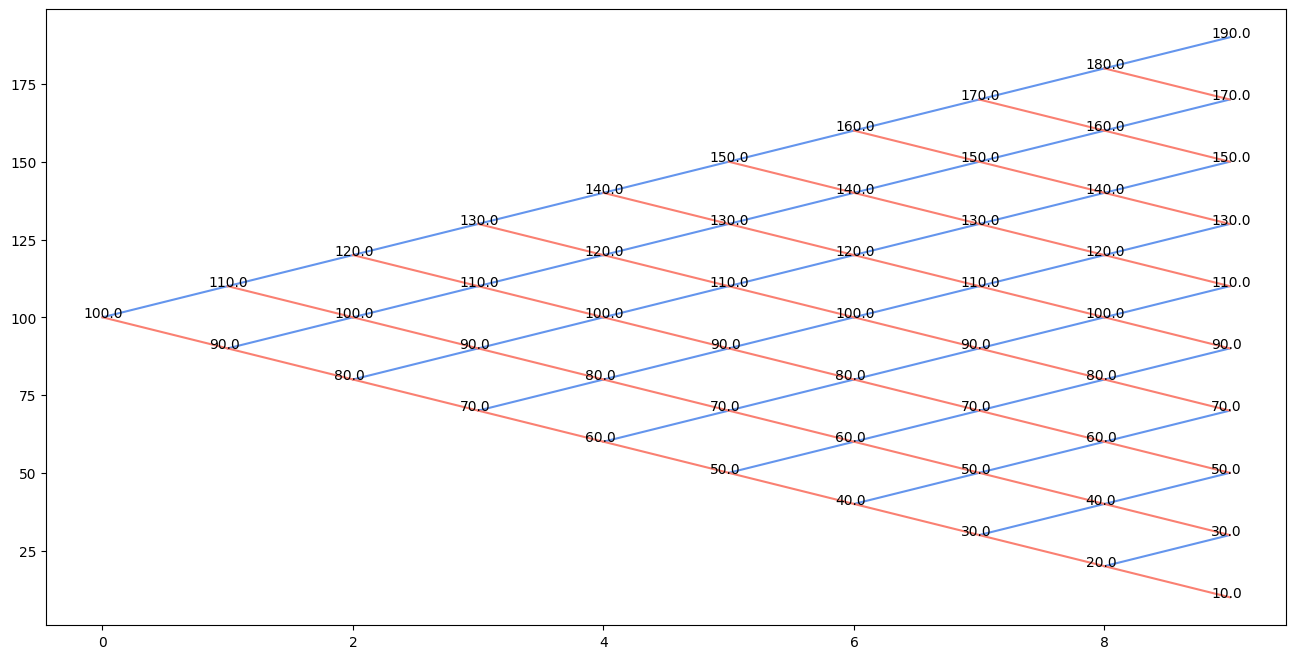

In [37]:
tree.fake_tree()

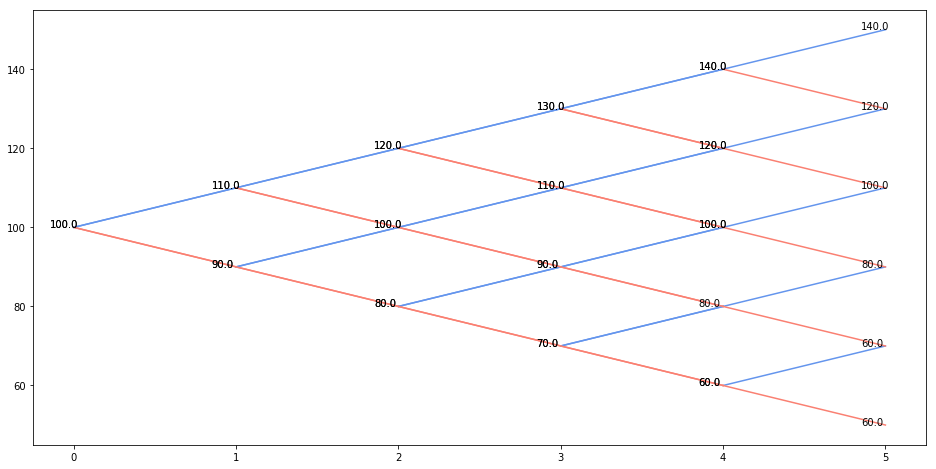

In [72]:
graph_tree(Tree(2,4).skeleton_tree(),graph_type = "real", up_color="cornflowerblue", down_color= "salmon", text_color="black")

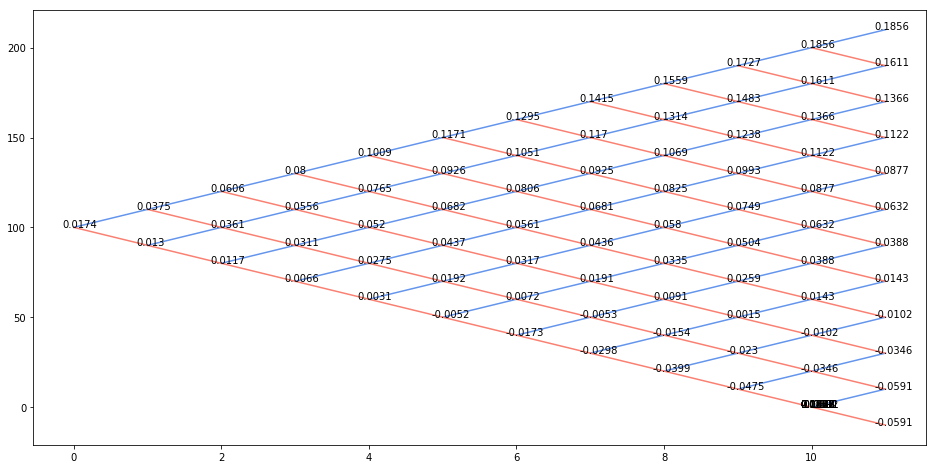

In [73]:
graph_tree(Tree(5,10).ho_lee(0.0174,0.0173,theta), graph_type= "")

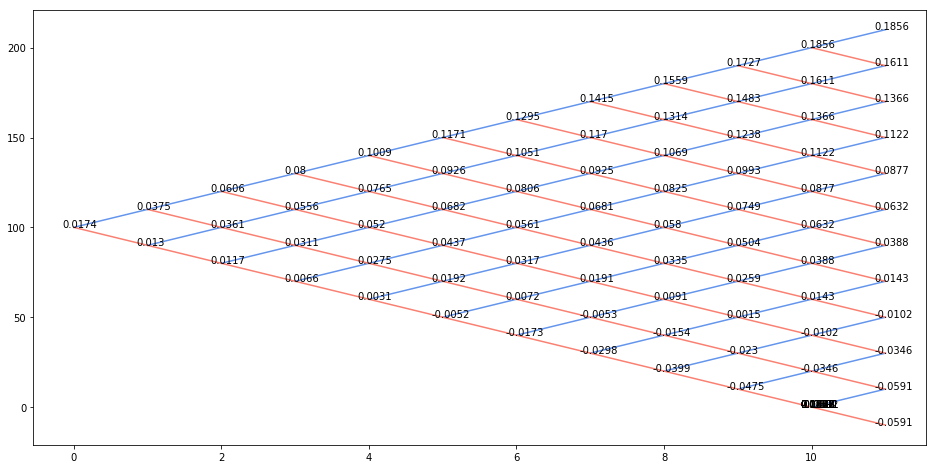

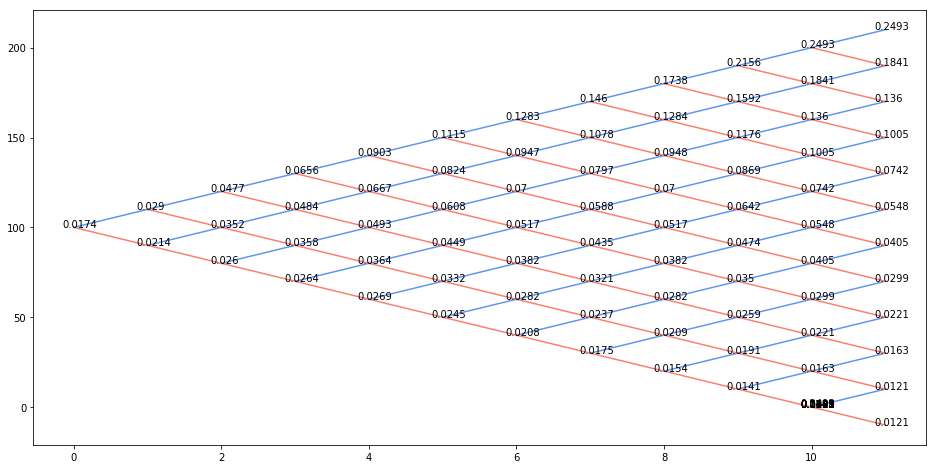

In [76]:
graph_tree(Tree(5,10).ho_lee(0.0174,0.0173,theta))
graph_tree(Tree(5,10).bdt(0.0174,0.2142,theta1))

In [417]:
zcb = [0.9758, 0.9527, 0.9289, 0.9050, 0.8808, 
      0.8565, 0.8327, 0.8090, 0.7858, 0.7628]

In [382]:
pwd

'd:\\GitHub\\BinomialTree'